In [230]:
%matplotlib notebook
from quantum_builder import QuantumBuilder
import logging
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
from matplotlib import cm
import qutip as qt
plt.style.use("support-files/qubit.mplstyle")

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
GHz = 10**9
MHz = 10**6
fF = 10**(-15)
e = 1.6*10**(-19)
h = 6.64*10**(-34)

# Resonators
Qubits will interact with different modes of the resonator.

The strength of the coupling will depend on this position:
\begin{equation}
 g = \frac{\pi{E_s}C_{q-r}}{2e}\sqrt{\frac{\hbar\omega_r}{C_r}}\cos(n\pi{\frac{x}{L}})
\end{equation}

- Cosine comes from the positon of the resonator
- $\sqrt{\frac{\hbar\omega_r}{C_r}}$ is the voltage in the resonator
- $C_{q-r}$ is the coupling capacitance between resonator and qubit
- $\frac{\pi{E_s}}{2e}$ is the voltage on the CQPS qubit associated with a phase slip event

<IPython.core.display.Javascript object>


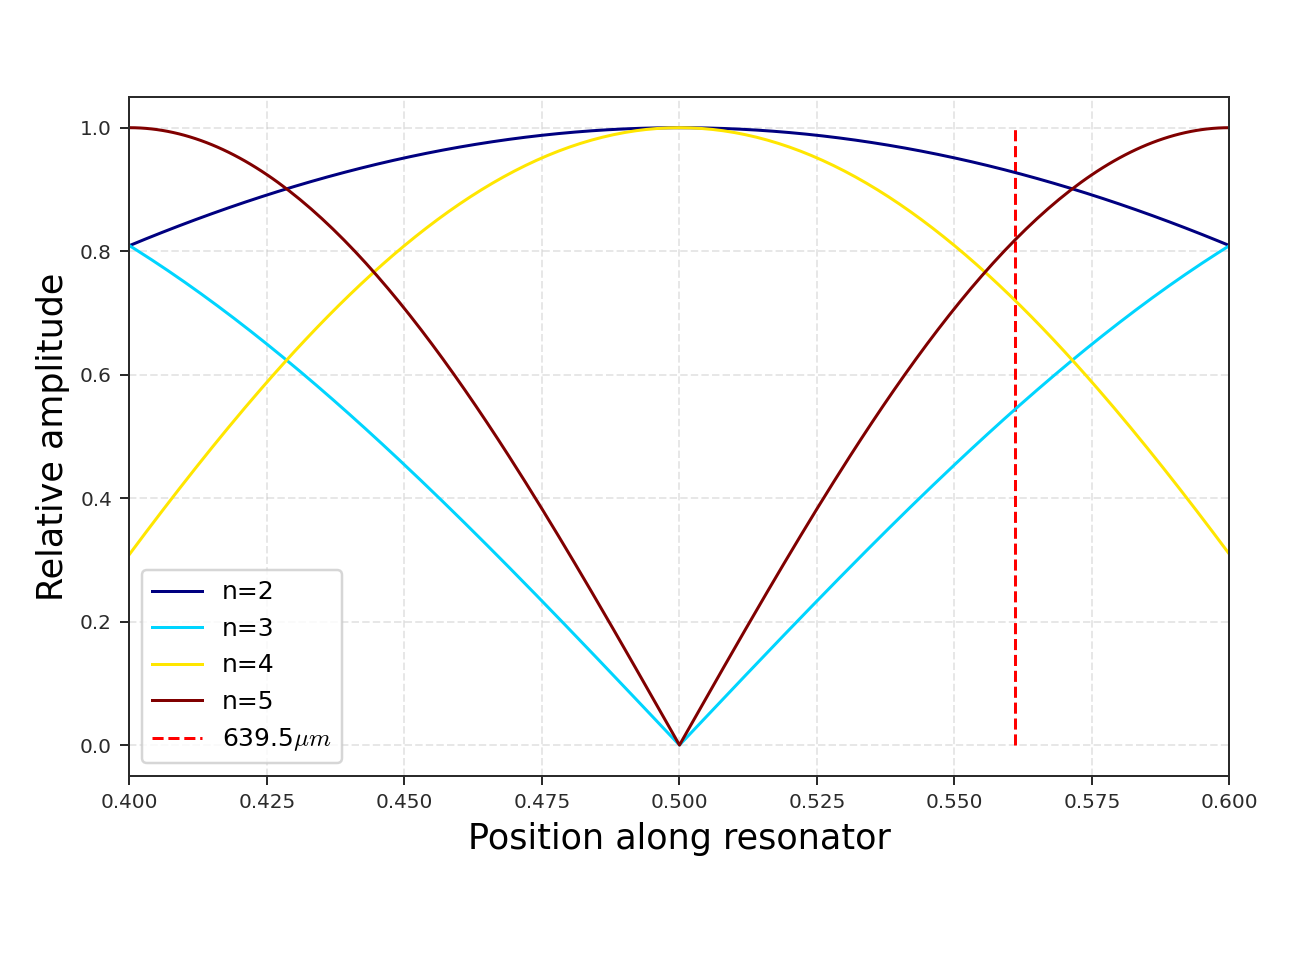

In [368]:
L = 1140
qubit_positions = [1/2 + 69.5/L]
N = [2, 3, 4, 5]

def resonator_voltage_scaling(x: float, mode: int):
    "x is in units between 0 and 1"
    return np.abs(np.cos(mode * np.pi * x))
    

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = plt.cm.jet(np.linspace(0, 1, len(N)))
x = np.linspace(0, 1, 1001)

# Plot voltage modes
for idx, n in enumerate(N):
    ax.plot(x, resonator_voltage_scaling(x, n), 
            color=cm[idx], label=f"n={n}")

# Plot qubit positions
for q in qubit_positions:
      ax.vlines(q, 0, 1, color="red", linestyles='--', label=f"{1140*q}$\mu{{m}}$")
        
ax.set_xlim([0.4, 0.6])
ax.set_xlabel("Position along resonator")
ax.set_ylabel("Relative amplitude")
ax.legend()

# Fitting of qubit spectrum
First we evalaute the transition energies of the cqps system
\begin{equation}
\mathcal{H} = E_L(\hat{n} - f)^2 - \frac{E_s}{2}\bigg[\left|n+1\right\rangle{\left\langle{n}\right|} + \left|n\right\rangle{\left\langle{n+1}\right|}\bigg],
\end{equation}

(It is very similar to the transmon Hamiltonian)
\begin{equation}
    \mathcal{H} = E_C{\left(\hat{N}-N_\text{ext}\right)^2}- \frac{E_J}{2}\bigg(\left|n+1\right\rangle{\left\langle n\right|}+\left|n\right\rangle{\left\langle n+1\right|}\bigg)
\end{equation}
    
I will simply use the transmon Hamitlonian to evaluate energies

<IPython.core.display.Javascript object>


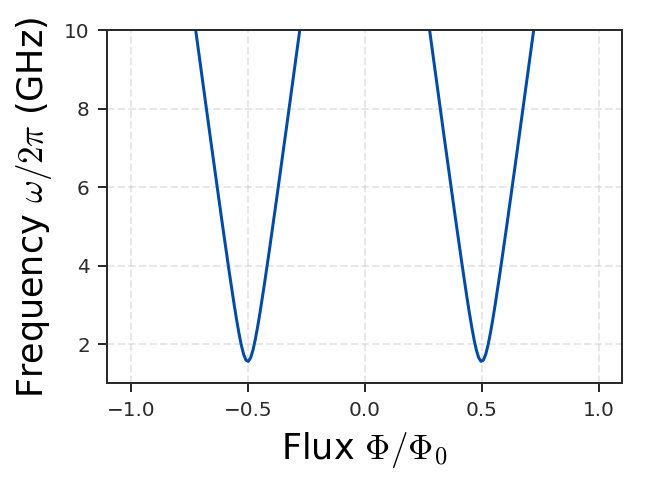

In [48]:
# Here we create the object with which we simulate cqps energies (very simple Hamiltonian). This is reused in all further cells
SIMULATION_PARAMETERS = {
    "number_of_states": 13,
    "number_of_levels_to_simulate": 2
}
QUBIT_PARAMETERS = {
    # We will override them in subsequent evaluations
    "ES": 10,
    "inductive_loop_squares": 30, # 30 140x140nm squares
     **SIMULATION_PARAMETERS
}
cqps_qubit = QuantumBuilder.build_cqps_qubit(
    QUBIT_PARAMETERS, logging_level=logging.ERROR,
)

# Example invocation
FLUX_NUMBER = np.linspace(-1, 1, 200)
EL = 22.2
ES = 1.56
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
simulation_graph, = ax.plot(FLUX_NUMBER, qubit_f01)

ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([1,10])
plt.tight_layout()

# Next we inroduce interaction with the resonator
*Hamitlonian at this stage*

\begin{equation}
 \frac{1}{\hbar}H_{qubit-resonator} = \frac{\omega_{q}}{2}\sigma_z + \omega_r{a^{\dagger}}a + g(a^{\dagger} + a)\sigma_x
\end{equation}

In the truncated matrix form between states $\left|e, N\right\rangle$ and $\left|g, N+1\right\rangle$
\begin{equation}
  \mathcal{H}_{middle} = \begin{pmatrix}
    \frac{\omega_q}{2} + (N)\omega_r & g\sqrt{N+1}\\
    g\sqrt{N+1} & -\frac{\omega_q}{2} + (N+1)\omega_r
  \end{pmatrix}
\end{equation}

We introduce the detuning factor $\delta =\omega_{q} - \omega_{r}$ in order to write out

\begin{equation}
  \mathcal{H}_{middle} = \begin{pmatrix}
    \frac{\delta}{2} + (N+\frac{1}{2})\omega_r & g\sqrt{N+1}\\
    g\sqrt{N+1} & -\frac{\delta}{2} + (N+\frac{1}{2})\omega_r
  \end{pmatrix}
\end{equation}

which reads as
\begin{equation}
  \begin{aligned}
      &= {\hbar\omega_r(N+\frac{1}{2})\mathbb{I} +\frac{ \hbar\delta}{2}\sigma_z} + {\hbar g_0\sqrt{N+1}\sigma_x}\\
      & = {\hbar\omega_r(N+\frac{1}{2})\mathbb{I}} + \frac{1}{2}\sqrt{(\hbar\delta)^2 + 4\hbar^2g_0^2(N+1)} \bigg(\cos(\theta)\sigma_z + \sin(\theta)\sigma_x\bigg)\\
      & = \hbar\omega_r(N+\frac{1}{2})\mathbb{I} + E_{\text{coupled}}(\cos(\theta)\sigma_z + \sin(\theta)\sigma_x)\\
      & \text{where } E_\text{coupled} = \frac{\hbar}{2}\sqrt{\delta^2 + 4g_0^2(N+1)};\qquad \tan(\theta) = \frac{g_0\sqrt{N+1}}{\delta/2}.
  \end{aligned}
\end{equation}

and thus, like in the paper after doing the torating frame

\begin{equation}
\frac{E}{\hbar} = \left( n + \frac{1}{2} \right)\omega_{r} + \frac{\omega_q}{2} \pm \sqrt{\left( \frac{\delta}{2} \right)^2 + g_0^2(N+1)}
\end{equation}

At `N = 0`

\begin{equation}
 \frac{E}{\hbar} = \frac{\omega_{r}}{2} + \frac{\omega_{q}}{2} \pm \sqrt{\left( \frac{\delta}{2} \right)^{2} + g^2}
\end{equation}

**All in units of radians. Therefore any measurement on the VNA is actually $X/2\pi$**

*e.g. we are fitting $g/2\pi$ to the experimental results*

<IPython.core.display.Javascript object>


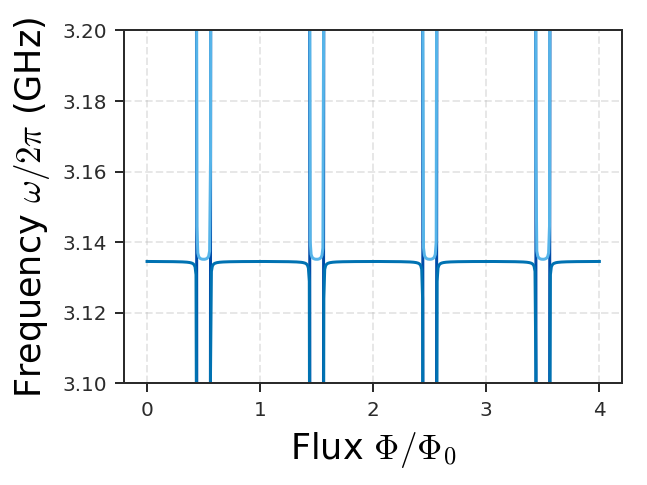

In [231]:
def qubit_resonator_spectrum(qubit_f01: list, resonator_f: float, g: float):
    "See equation (6) above"
    e_high = []
    e_low = []
    
    for dQubit in qubit_f01:
        a = dQubit / 2
        b = resonator_f / 2
        c = (dQubit - resonator_f) / 2

        factor = np.sqrt(c**2 + g**2)
        e_high.append(a+b+factor)
        e_low.append(a+b-factor)
        
    return (e_low, e_high)

# Example invocation
g = 29.9 * (MHz/GHz) # Everything is done in GHz, but MHz is the natural scale
resonator_f = 3.13461
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f, g)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
qubit_graph, = ax.plot(FLUX_NUMBER, qubit_f01)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low)
e_high_plot, = ax.plot(FLUX_NUMBER, e_high)

ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([3.1,3.2])
plt.tight_layout()

# Master equations simulation

We are solving the master equation for the full system

 \begin{equation}
  \begin{aligned}
    \dot{\rho} = -\frac{i}{\hbar}\left[ \mathcal{H}, \rho \right] + \mathcal{L}\left[ \rho \right] & = i\frac{\delta_{q}}{2}\left[ \sigma_z\rho - \rho\sigma_z \right] -i\delta_{r}\left[ {a}^{\dagger}a\rho - \rho{a}^{\dagger}a \right]\\
    & - ig{\left[ a\sigma_+\rho - \rho{a}\sigma_+ + {a}^{\dagger}\sigma_{-}\rho - \rho{a}^{\dagger}\sigma_{-} \right]}\\
    & - i{\frac{\Omega}{2}}\left[ a\rho - \rho{a} + {a}^{\dagger}\rho - \rho{a}^{\dagger} \right]\\
    & + \frac{\kappa}{2}\left[ 2a\rho{a}^{\dagger} - {a}^{\dagger}a\rho - \rho{a}^{\dagger}a \right]\\
    & + \frac{\Gamma_{1}}{2}\left[ 2\sigma_{-}\rho\sigma_{+} - \sigma_+\sigma_{-}\rho - \rho\sigma_+\sigma_{-} \right]\\
    & + \frac{\Gamma_{\phi}}{2}\left[ \sigma_z\rho\sigma_z - \rho \right]
  \end{aligned}
 \end{equation}


## Representation in 2 qubit - 2 resonator basis (N=0, N=1)

We will use the truncated subspace of vectors in the following $\left|e, n\right\rangle, \left|e, n+1\right\rangle, \left|g, n\right\rangle, \left|g, n+1\right\rangle$ with $n=0$

The representation of operator $\hat{A}$ in this subspace will be
\begin{equation}
 \begin{pmatrix}
   \left\langle e, n\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n\right|\hat{A}{\left|g, n\right\rangle} & \left\langle e, n\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle e, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|g, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle g, n\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n\right|\hat{A}{\left|g, n\right\rangle} & \left\langle g, n\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle g, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|g, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|g, n+1\right\rangle}\\
 \end{pmatrix}
\end{equation}

In [60]:
NR = 2
OFFSET = 0

qubit_ket = qt.basis(2,0)
resonator_ket = qt.basis(NR, 0)
example_state = qt.tensor(
    [
        qt.ket2dm(qubit_ket), 
        qt.ket2dm(resonator_ket)
    ])
example_state

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  \sigma_z =
  \begin{pmatrix}
    1 & . & . & . \\
    . & 1 & . & . \\
    . & . & -1 & .\\
    . & . & . & -1
  \end{pmatrix}
\end{equation}

In [64]:
op_sigmaz = qt.tensor(
    qt.sigmaz(),
    qt.identity(NR)
)
op_sigmaz

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]

\begin{equation}
  a=
  \begin{pmatrix}
    . & \sqrt{n+1} & . & . \\
    . & .& .& .\\
    . & . & . & \sqrt{n+1} \\
    . & . & . & .
  \end{pmatrix}
\end{equation}

In [65]:
op_a = qt.tensor(
    qt.identity(2),
    qt.destroy(NR, offset=OFFSET)
)
op_a

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}=
  \begin{pmatrix}
    . & . & . & . \\
    \sqrt{n} & .& .& .\\
    . & . & . & . \\
    . & . & \sqrt{n} & .
  \end{pmatrix}
\end{equation}


In [66]:
op_adagger = qt.tensor(
    qt.identity(2),
    qt.create(NR, offset=OFFSET)
)
op_adagger

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]

\begin{equation}
  \sigma_{-} =
  \begin{pmatrix}
    . & . & . & . \\
    . & . & . & . \\
    1 & . & . & . \\
    . & 1 & . & .
  \end{pmatrix}
\end{equation}

In [67]:
op_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.identity(NR)
)
op_sigmaminus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

\begin{equation}
  \sigma_{+} =
  \begin{pmatrix}
    . & . & 1 & . \\
    . & . & . & 1 \\
    . & . & . & . \\
    . & . & . & .
  \end{pmatrix}
\end{equation}

In [68]:
op_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.identity(NR)
)
op_sigmaplus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}a =
  \begin{pmatrix}
    n & . & . & . \\
    . & n+1 & . & . \\
    . & . & n & . \\
    . & . & . & n+1
  \end{pmatrix}
\end{equation}

In [61]:
op_n = qt.tensor(
    qt.identity(2),
    qt.num(NR, offset=OFFSET)
)
op_n

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

\begin{equation}
  a\sigma_{+}=
  \begin{pmatrix}
    . & . & . & \sqrt{n+1} \\
    . & . & . & . \\
    . & . & . & . \\
    . & . & . & .
  \end{pmatrix}
\end{equation}


In [62]:
op_a_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.destroy(NR, offset=OFFSET)
)
op_a_sigmaplus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}\sigma_-=
  \begin{pmatrix}
    . & . & . & . \\
    . & . & . & . \\
    . & . & . & . \\
    \sqrt{n+1} & . & . & .
  \end{pmatrix}
\end{equation}

In [63]:
op_adagger_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.create(NR, offset=OFFSET)
)
op_adagger_sigmaminus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]

## Analytical solution from mathematica
- Using **very** inefficient methods (manual substitution, since Mathematica chockes when told to solve for the 4x4 equations), we have found an analytical solution in the case of weak drive
- $\Omega << 1$ and therefore $\mathcal{O(\Omega^2)}$  terms were set to 0

- The expectation values:

\begin{equation}
  \begin{aligned}
 \left\langle a \right\rangle & = -i{\frac{\Omega/2}{\frac{g^{2}}{\frac{\Gamma_{1}}{2}+\Gamma_{\phi}+i\delta_q} + \left( \frac{\kappa}{2}+i\delta_r \right)}}\\
    &={\frac{\Omega/2}{\frac{g^{2}}{\delta_{q}-i{\left( \frac{\Gamma_{1}}{2}+\Gamma_{\phi} \right)}} - (\delta_r - i\frac{\kappa}{2})}}\\
  \end{aligned}
\end{equation}
\begin{equation}
  \begin{aligned}
     \left\langle a^\dagger \right\rangle &= i{\frac{\Omega/2}{\frac{g^{2}}{\frac{\Gamma_{1}}{2}+\Gamma_{\phi}-i\delta_q} + \left( \frac{\kappa}{2}-i\delta_r \right)}}\\
     &={\frac{\Omega/2}{\frac{g^{2}}{\delta_{q}+i{\left( \frac{\Gamma_{1}}{2}+\Gamma_{\phi} \right)}} - (\delta_r + i\frac{\kappa}{2})}}\\
  \end{aligned}
\end{equation}

- Solutions give the field in the resonator at the output line  and thus the voltage in the resonator
\begin{equation}
 V_r{\left( \left\langle a \right\rangle + \left\langle a^{\dagger} \right\rangle  \right)}
\end{equation}
This field induces a displacement current across capacitance $C_k$ through which the resonator couples to the output line $V_{resonator}/Z_{gap} = V_{resonator} / \frac{1}{i\omega{C_k}}$ which generates a voltage output line with impedance Z
\begin{equation}
 V_{out}(t) \approx V_r{\left( \left\langle a^{\dagger} \right\rangle + \left\langle a \right\rangle  \right)} \left[ -i\omega{C_{k}} \right]Z
\end{equation}

- Subbing in the values will give
\begin{equation}
\begin{aligned}
V_{out}(t) & = -i\omega{C_{k}}Z V_r \left[\frac{\Omega/2}{g^2/\delta_q' - \delta_r'}+cc\right]\\
& = -i\omega{C_{k}}Z V_r \frac{\Omega}{2}\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
 & = -i\omega{C_{k}}Z V_r \left[\frac{C_{k}V_{in}V_r}{\hbar}\frac{1}{2}\right]\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
 & = -i\omega{C_k^2Z}V_{in} \left[ \frac{1}{\hbar}\frac{1}{2} \right] \frac{\hbar\omega}{C_{r}}\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
 & = -i\frac{1}{2}V_{in}\frac{C_k^2\omega^2Z}{C_{r}}\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
\end{aligned}
\end{equation}

where:
- $\delta_{q}'=\delta_{q} + i\left( \frac{\Gamma_1}{2}+\Gamma_{\phi} \right)$
- $\delta_{r}'=\delta_{r} +i\frac{\kappa}{2}$

Then a simple ratio gives the transmission coefficient:
\begin{equation}
 t = \frac{V_{out}}{V_{in}} = -i\frac{1}{2}\frac{C_k^2\omega^2Z}{C_{r}}\left[ \frac{1}{g^2/\delta_q' - \delta_r'} + cc\right]
\end{equation}

which can be expanded in mathematica (bracket section)
\begin{equation}
\frac{2 g^2 \delta _q-2 \delta _q^2 \delta _r-2 \Gamma ^2 \delta _r}{\left(\Gamma  \kappa '+g^2\right)^2-2 g^2 \delta _q \delta _r+\delta _q^2 \left(\left(\kappa '\right)^2+\delta _r^2\right)+\Gamma ^2 \delta _r^2}
\end{equation}

<IPython.core.display.Javascript object>


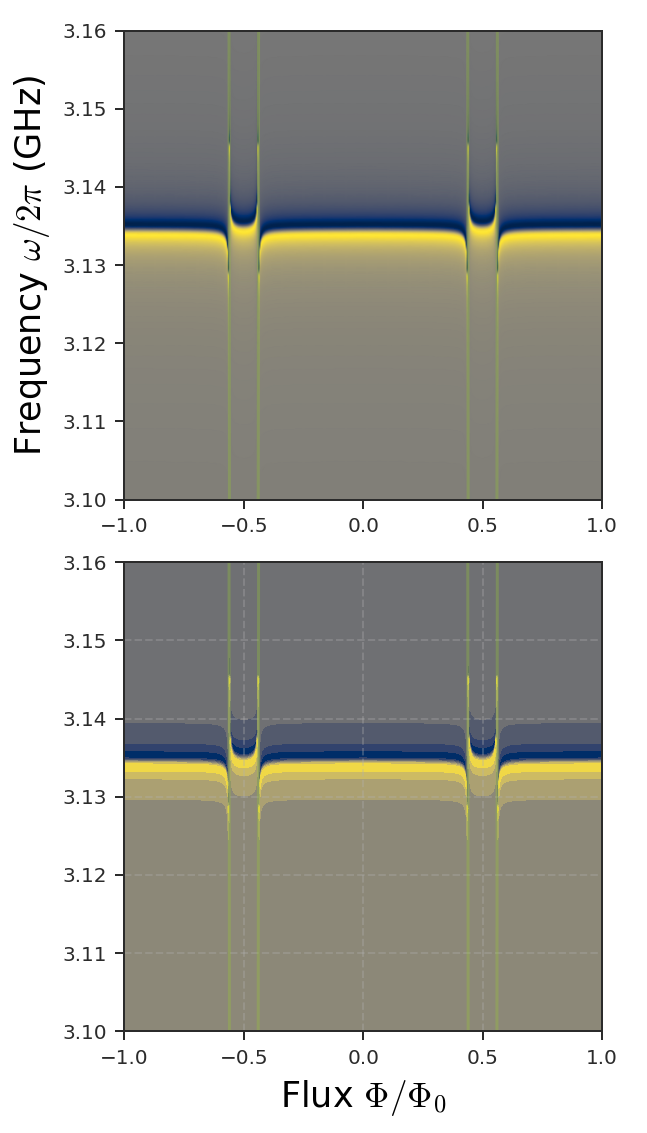

<ipython-input-282-982e7d38a3bb>:71: UserWarning: The following kwargs were not used by contour: 'sharex'
  ax.contourf(deltaXMesh, deltaYMesh, np.transpose(tGrid), cmap=cm.cividis,sharex=ax_arr[0])


In [282]:
def make_transmission_function(Gamma1: float, GammaPhi:float, kappa: float, g: float):
    """
    Function defined within a function, so that it has seeded parameters for constant parameters
    
    See mathematica notebook for how this expansion was found.
    
    Make sure everything is in MHz (or everything is in GHz)
    """
    Gamma = Gamma1/2 + GammaPhi
    kappaPrime = kappa / 2
    twoGSquared = 2*g**2
    twoGammaSquared = 2*Gamma**2
    GammaSquared=Gamma**2
    gSquaredPlusGammaKappaPrimed_allSquared = (g**2 + Gamma*kappaPrime)**2
    kappaPrimeSquared = kappaPrime**2
    
    def transmission(delta_q: float, delta_r: float) -> float:
        delta_qSquared = delta_q**2
        delta_rSquared = delta_r**2
        return (
            (twoGSquared*delta_q - twoGammaSquared*delta_r - 2*delta_qSquared*delta_r)
            / 
            (- twoGSquared*delta_q*delta_r 
             + GammaSquared*delta_rSquared 
             + gSquaredPlusGammaKappaPrimed_allSquared 
             + delta_qSquared*(delta_rSquared + kappaPrimeSquared))
        )
    return transmission

# Example application
Gamma1 = 0.26 # Will be fitted
GammaPhi = 0
kappa = 1.39 # Taken from paper
g = 25
resonator_f = 3.13461
sweep_f = np.linspace(3.1, 3.16, 501)

transmission = make_transmission_function(Gamma1, GammaPhi, kappa, g)

# Simulate qubit
FLUX_NUMBER = np.linspace(-1, 1, 501)
EL = 22.2
ES = 1.56
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Construct a matrix of detunings. We step along the magnetic field (changing the freqyency of the qubit) and 
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000 #to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

# Simulate qubit-resonator
tGrid = transmission(deltaQ, deltaR)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

# Plot
fig, ax_arr = plt.subplots(2, 1, figsize=(4, 7))
ax = ax_arr[0]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tGrid), 
              shading='gouraud', 
            cmap=cm.cividis);
ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"], alpha=0.3)

ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([sweep_f[0], sweep_f[-1]])

ax = ax_arr[1]
ax.contourf(deltaXMesh, deltaYMesh, np.transpose(tGrid), cmap=cm.cividis,sharex=ax_arr[0])
ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"], alpha=0.3)
ax.set_ylim([sweep_f[0], sweep_f[-1]])
ax.set_xlabel("Flux $\Phi/\Phi_0$")
plt.tight_layout()

# Qubit 12 Analysis

In [265]:
# Global parameters
PERIOD = 0.1818 # Should not be changed

## Qubit spectrum

In [266]:
FILENAME="./data/2020-07_cqps-single/text-data/TiN95_CQPS_C_July12'20_two_tone_44_data.txt"
OFFSET = 0.1836 - PERIOD/2

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
    
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)

<IPython.core.display.Javascript object>


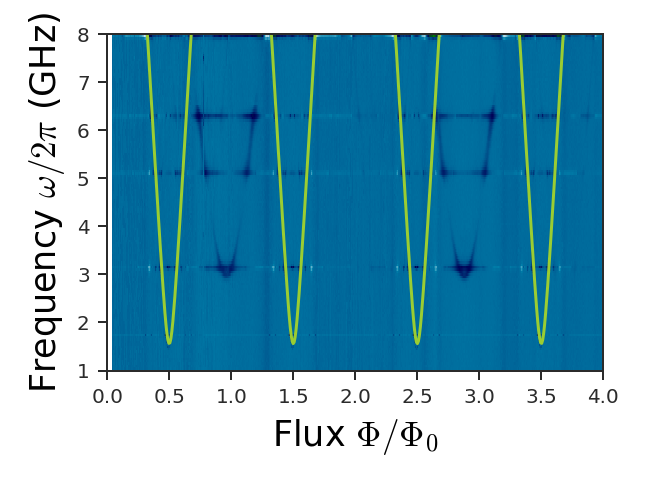

In [267]:
FLUX_NUMBER = np.linspace(0, 4, 500)
EL = 22.2
ES = 1.56

# Simulation
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
simulation_graph, = ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"])
# ax.plot(field, response,
#         linestyle="", markersize=3,
#         marker="o", color="orange")
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.ocean)

ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([1, 8])
ax.set_xlim([0, 4])
plt.tight_layout()

In [268]:
def update(ES: float, EL: float, toggle: bool):    
    cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)

    simulation = cqps_qubit.run_simulation(
        FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
    qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

    simulation_graph.set_ydata(qubit_f01)
    simulation_graph.set_visible(toggle)
    ax.relim()
    ax.autoscale_view()
    plt.tight_layout()
    
ES_widget = ipywidgets.FloatSlider(
    min=0, max=10, step=0.1,
    description="$ES (GHZ)$", value=ES,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
EL_widget = ipywidgets.FloatSlider(
    min=0, max=30, step=0.1,
    description="$EL (GHz)$", value=EL,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(3, 1)
ui[0,0] = ES_widget
ui[1,0] = EL_widget
ui[2,0] = toggle_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "ES": ES_widget,
        "EL": EL_widget,
        "toggle": toggle_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=1.56, description='$ES (GHZ)$', layout=Layout(grid_area='widget001'…

Output()

## Anticrossing on m=2
- g = 29.9MHz
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth
- Resonator paramters taken from Teresa's fittings

In [363]:
FILENAME="./data/2020-07_cqps-single/text-data/TiN95_CQPS_C_July12'20_mfield-3_13G_18_data.txt"
OFFSET = 1.4566 - PERIOD/2

resonator_f = 3.13461 #GHz
kappa = 2.07 #MHz

# These are in MHz
g = 29.9
Gamma1 = 20
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

<IPython.core.display.Javascript object>


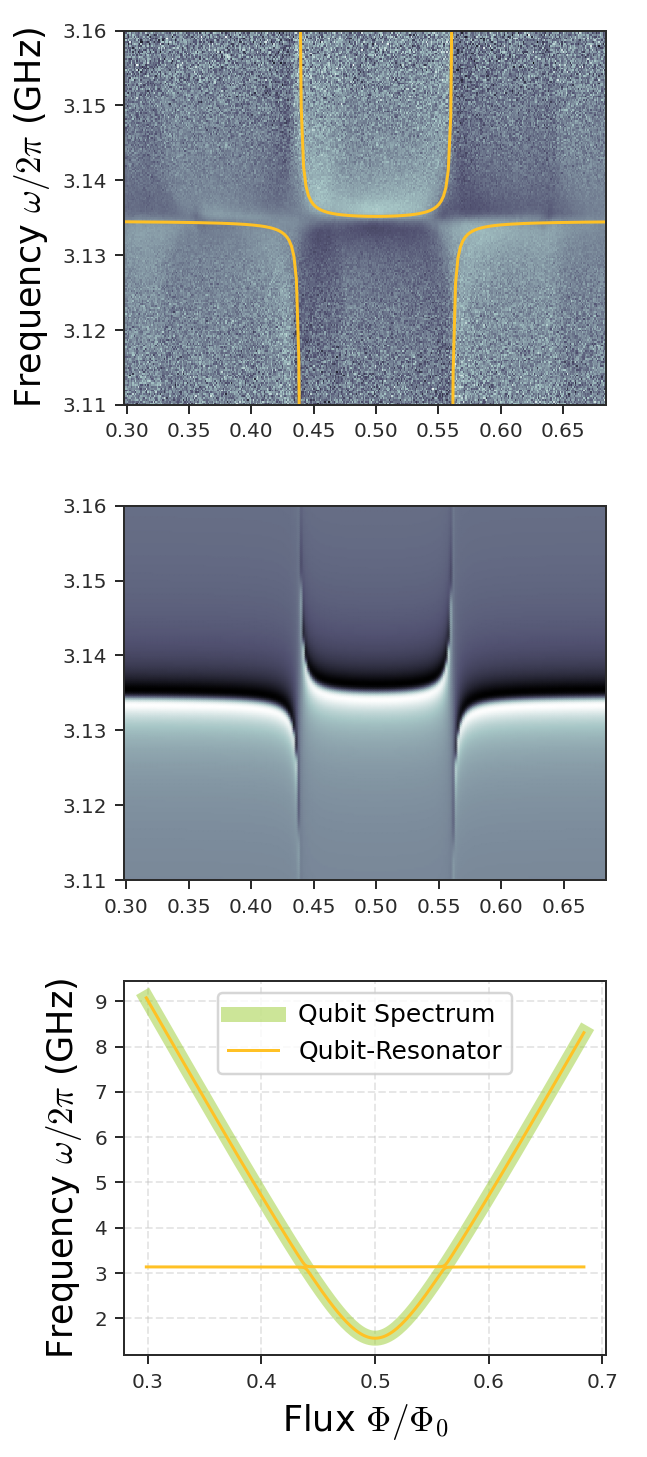

In [364]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(3, 1, figsize=(4, 9))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

ax = ax_arr[2]
ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
        linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
                            color=MY_COLOURS["Orange"])
e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
                             color=MY_COLOURS["Orange"],
                             label="Qubit-Resonator"
                             )
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.legend()

plt.tight_layout()

In [365]:
def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)    
    e_low_plot_LARGE.set_ydata(e_low)
    e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=3.13461, continuous_update=False, description='$f_r (GHz)$', layout…

Output()

In [366]:
plt.savefig(FILENAME.replace("txt","pdf"),dpi=100)

## Anticrossing on m=3
- g = 29.9MHz
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth

In [357]:
FILENAME="./data/2020-07_cqps-single/text-data/TiN95_CQPS_C_July12'20_mfield-5_12G_16_data.txt"
OFFSET = 1.4566 - PERIOD/2

resonator_f = 5.12 #GHz
kappa = 4.75 #MHz

# These are in MHz
g = 20
Gamma1 = 22
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

<IPython.core.display.Javascript object>


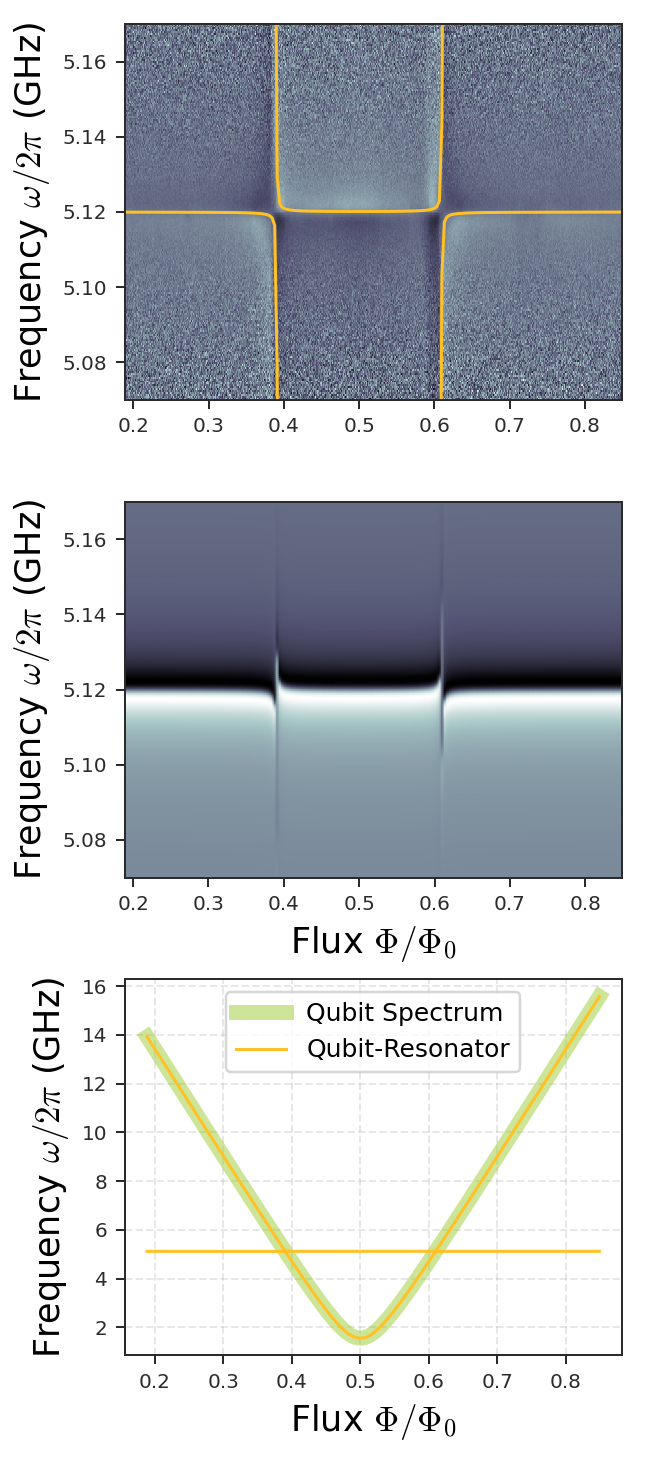

In [358]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(3, 1, figsize=(4, 9))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

ax = ax_arr[2]
ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
        linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
                            color=MY_COLOURS["Orange"])
e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
                             color=MY_COLOURS["Orange"],
                             label="Qubit-Resonator"
                             )
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.legend()

plt.tight_layout()

In [342]:
def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)    
    e_low_plot_LARGE.set_ydata(e_low)
    e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=5.12, continuous_update=False, description='$f_r (GHz)$', layout=La…

Output()

In [362]:
plt.savefig(FILENAME.replace("txt","pdf"),dpi=100)

## Anitcrossing on m=4
- $g$ hard to define
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth

In [349]:
FILENAME="./data/2020-07_cqps-single/text-data/TiN95_CQPS_C_July12'20_mfield-6_3G_m15dBm_43_data.txt"
OFFSET = 0.1836 - PERIOD/2

resonator_f = 6.28143 #GHz
kappa = 8.5 #MHz

# These are in MHz
g = 20
Gamma1 = 22
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

<IPython.core.display.Javascript object>


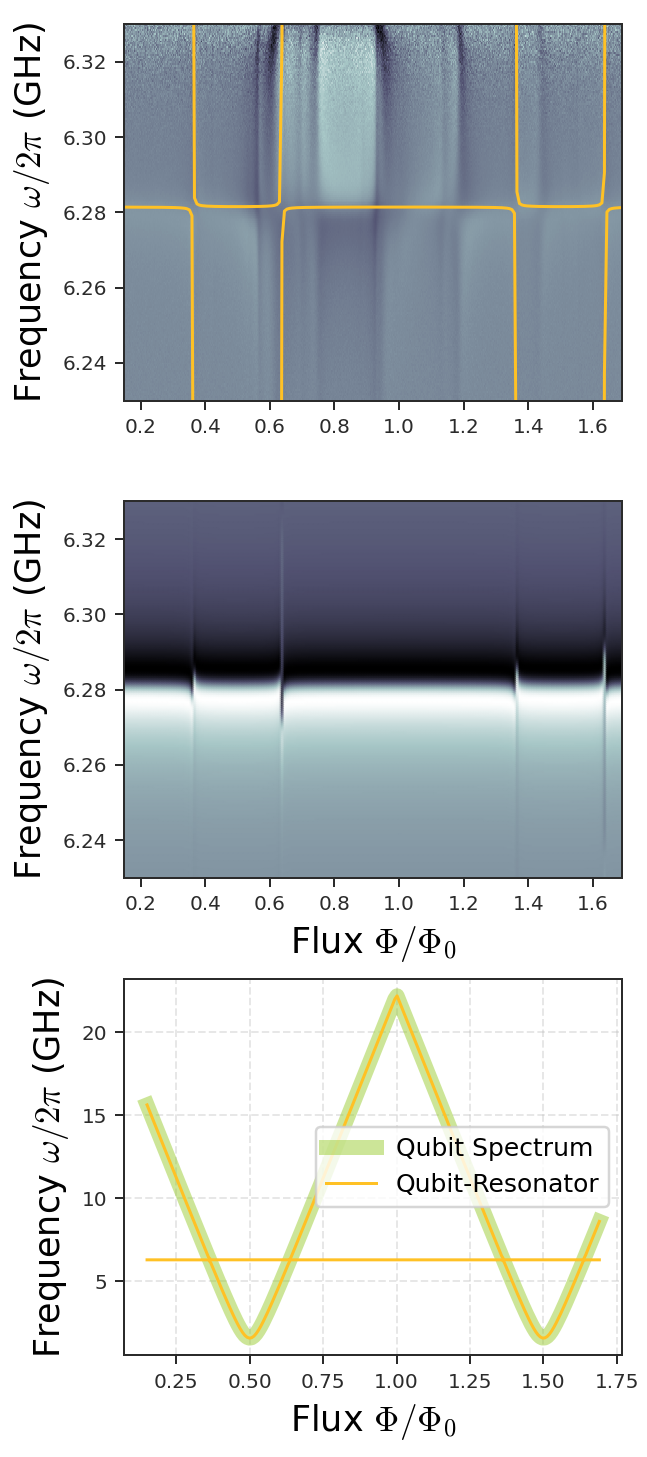

In [350]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(3, 1, figsize=(4, 9))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

ax = ax_arr[2]
ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
        linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
                            color=MY_COLOURS["Orange"])
e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
                             color=MY_COLOURS["Orange"],
                             label="Qubit-Resonator"
                             )
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.legend()

plt.tight_layout()

In [347]:
def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)    
    e_low_plot_LARGE.set_ydata(e_low)
    e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=6.28143, continuous_update=False, description='$f_r (GHz)$', layout…

Output()

## Anitcrossing on m=5
- g = 44MHz
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth

In [352]:
FILENAME="./data/2020-07_cqps-single/text-data/TiN95_CQPS_C_July12'20_mfield-7_9G_m15dBm_38_data.txt"
OFFSET = 0.1836 - PERIOD/2

resonator_f = 7.9395 #GHz
kappa = 11.1 #MHz

# These are in MHz
g = 44
Gamma1 = 22
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

<IPython.core.display.Javascript object>


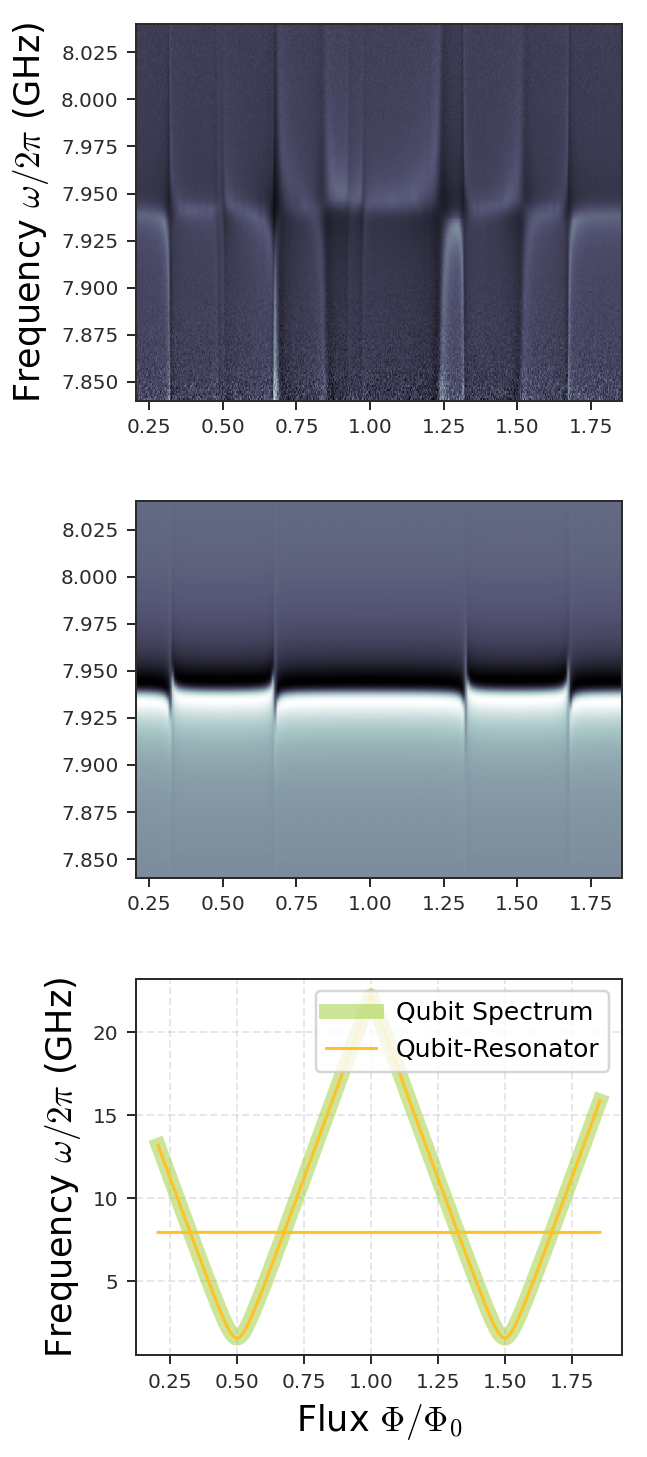

In [353]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(3, 1, figsize=(4, 9))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

ax = ax_arr[2]
ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
        linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
                            color=MY_COLOURS["Orange"])
e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
                             color=MY_COLOURS["Orange"],
                             label="Qubit-Resonator"
                             )
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.legend()

plt.tight_layout()

In [355]:
def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)    
    e_low_plot_LARGE.set_ydata(e_low)
    e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=7.9395, continuous_update=False, description='$f_r (GHz)$', layout=…

Output()

## Anticrossing summary
Since we have
\begin{equation}
 g = \frac{\pi{E_s}C_{q-r}}{2e}\sqrt{\frac{\hbar\omega_r}{C_r}}\cos(n\pi{\frac{x}{L}})
\end{equation}

We should be able to plot g vs $\sqrt{nf_{fundametal}}\cos(n\pi{\frac{x}{L}})$ with
- $L=1140$
- $x = L/2 + 69.5$
- $f_{fundametal}=3.13461/2$

<IPython.core.display.Javascript object>


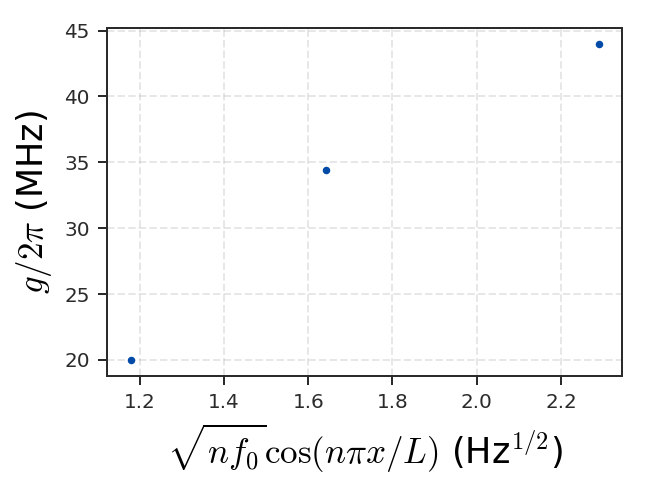

In [367]:
f_fundametal = 3.13461/2 #GHz
L = 1140 #µm
qubit_position = 1/2 + 69.5/L
g_solutions = {
    2: 34.45,
    3: 20,
    5: 44
}

# Generate plot data
x_values = [
    (
        np.sqrt(n*f_fundametal) 
        * np.abs(np.cos(n*np.pi*qubit_position))
    )
    for n in g_solutions.keys()
     ]
y_values = g_solutions.values()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(x_values, y_values, linestyle="", marker="o")
ax.set_xlabel("$\sqrt{nf_0}\cos(n\pi{x}/L)$ (Hz$^{1/2}$)")
ax.set_ylabel("$g/2\pi$ (MHz)")
plt.tight_layout()

plt.savefig("data/2020-07_cqps-single/qubit12_g-from-anticrossing.pdf",dpi=100)